# Analyze cell-gene matrix
This Python Jupyter notebook processes the cell-gene matrix for basic purposes such as removing doublets and examining the amount of viral products per cell.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - input_matrix: filtered gene-barcode matrix from `STARsolo`
#  - input_features: list of features (genes) from `STARsolo`
#  - input_barcodes: list of cell barcodes from `STARsolo`
#  - input_viral_gtf: GTF file giving names of viral genes

In [2]:
# Parameters
input_matrix = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/matrix.mtx"
input_features = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/features.tsv"
input_barcodes = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/barcodes.tsv"
input_viral_gtf = "data/flu_sequences/flu-CA09.gtf"
input_viraltag_counts = "results/viral_fastq10x/viraltag_counts_hashing_trial2.csv"

## Import Python modules
We use [anndata](https://anndata.readthedocs.io/) and [scanpy](https://scanpy.readthedocs.io/) for most the data processing, and [plotnine](https://plotnine.readthedocs.io/) for ggplot2-style plotting:

In [3]:
import os

import anndata
import BCBio.GFF
from IPython.display import display, HTML
import numpy
import pandas as pd
from plotnine import *
import scanpy as sc

Set [scanpy](https://scanpy.readthedocs.io/) to provide lots of information including hints:

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

Versions of key [scanpy](https://scanpy.readthedocs.io/) packages:

In [5]:
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1


Color-blind palette:

In [6]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [7]:
_ = theme_set(theme_classic)

## Read the cell-gene matrix
Read the cell-gene matrix into an [AnnData](https://anndata.readthedocs.io/) annotated data object.
We can't _quite_ use the [scanpy read_10x_mtx](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.read_10x_mtx.html) function as the `STARsolo` output isn't in quite the write format, so instead we write our own code that accomplishes the same:

In [8]:
print(f"Reading cell-gene matrix from {input_matrix}")
adata = anndata.read_mtx(input_matrix).T

print(f"Reading features (genes) from {input_features}")
genes = pd.read_csv(input_features, header=None, sep='\t')
adata.var_names = (anndata.utils.make_index_unique(pd.Index(genes[1]))
                   .rename('gene_symbols')
                   )
adata.var['gene_ids'] = genes[0].values

print(f"Reading barcodes (cells) from {input_barcodes}")
cells = pd.read_csv(input_barcodes, header=None, sep='\t')[0]
adata.obs_names = cells.rename('cell_barcodes')

print(f"\nInfo on created annotated data object:\n{adata}")

Reading cell-gene matrix from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/matrix.mtx
Reading features (genes) from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/features.tsv
Reading barcodes (cells) from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/barcodes.tsv

Info on created annotated data object:
AnnData object with n_obs × n_vars = 3734 × 30959 
    var: 'gene_ids'


## Basic analysis of total and viral UMIs per cell

### Total UMIs per cell
Annotate and plot total UMIs per cell:

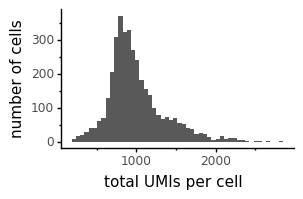

In [9]:
adata.obs['total_UMIs'] = numpy.sum(adata.X, axis=1).A1

p = (ggplot(adata.obs, aes('total_UMIs')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('total UMIs per cell') +
     ylab('number of cells')
     )
_ = p.draw()

### Viral UMIs per cell
First get the viral transcripts:

In [10]:
print(f"Reading names of viral transcripts from {input_viral_gtf}")
with open(input_viral_gtf) as f:
    viral_genes = [seqrecord.id for seqrecord in BCBio.GFF.parse(f)]
    
print('The viral transcripts are as follows:\n\t' + '\n\t'.join(viral_genes))

assert set(viral_genes) <= set(adata.var_names), "missing some viral genes"

Reading names of viral transcripts from data/flu_sequences/flu-CA09.gtf
The viral transcripts are as follows:
	fluHA
	fluM
	fluNA
	fluNP
	fluNS
	fluPA
	fluPB1
	fluPB2


Now annotate and plot total viral UMIs per cell:

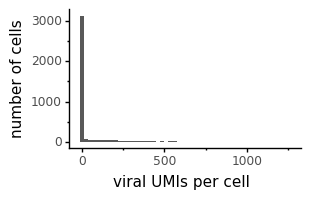

In [11]:
adata.obs['viral_UMIs'] = numpy.sum(adata[:, viral_genes].X, axis=1).A1

p = (ggplot(adata.obs, aes('viral_UMIs')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('viral UMIs per cell') +
     ylab('number of cells')
     )
_ = p.draw()

Also annotate total cellular (non viral) UMIs per cell:

In [12]:
adata.obs['cellular_UMIs'] = adata.obs['total_UMIs'] - adata.obs['viral_UMIs']

And annotate the fraction of UMIs that are viral:

In [13]:
adata.obs['viral_UMI_frac'] = adata.obs['viral_UMIs'] / adata.obs['total_UMIs']

### Correlation between viral and total/cellular UMIs
Below calculate the correlation between the viral and total and cellular mRNAs:

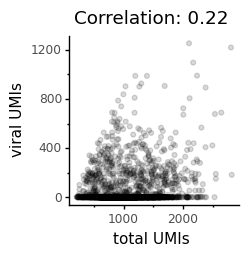

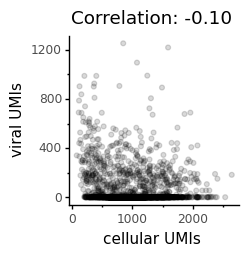

In [14]:
for x in ['total_UMIs', 'cellular_UMIs']:
    
    corr = adata.obs[x].corr(adata.obs['viral_UMIs'], method='pearson')
    
    p = (ggplot(adata.obs, aes(x, 'viral_UMIs')) +
         geom_point(alpha=0.15) +
         theme(figure_size=(2.2, 2.2)) +
         xlab(x.replace('_', ' ')) +
         ylab('viral UMIs') +
         ggtitle(f"Correlation: {corr:.2f}")
         )
    _ = p.draw()

### Filter cells on total cellular UMIs
We filter cells that have unusually low or high number of UMIs.
We mark as `filtered` cells that fail the filter:

In [15]:
mean_cell_UMIs = adata.obs['cellular_UMIs'].mean()
limits = (mean_cell_UMIs / 2.5, mean_cell_UMIs * 2.5)

print(f"Average of {mean_cell_UMIs:.1f} cellular UMIs / cell.\nMarking as "
      f"filtered if <{limits[0]:.1f} or >{limits[1]:.1f} cellular UMIs.")

adata.obs = (
    adata.obs
    .assign(filtered=lambda x: ((x['cellular_UMIs'] < limits[0]) |
                                (x['cellular_UMIs'] > limits[1])),
            filtered_desc=lambda x: numpy.where(x['filtered'] != True, 'retained',
                                    numpy.where(x['cellular_UMIs'] < limits[0],
                                    'too few cellular UMIs', 'too many cellular UMIs')),
            )
    )

Average of 961.7 cellular UMIs / cell.
Marking as filtered if <384.7 or >2404.2 cellular UMIs.


Plot cellular and viral mRNAs in filtered versus retained cells

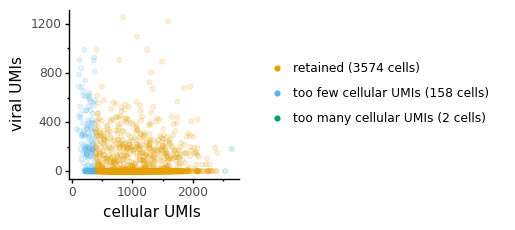

In [16]:
p = (ggplot(
        adata.obs.assign(ncells=lambda x: x.groupby('filtered_desc')
                                           ['filtered']
                                           .transform('count'),
                         cell_group=lambda x: x['filtered_desc'] + ' (' + 
                                              x['ncells'].astype(str) + ' cells)'
                         ),
        aes('cellular_UMIs', 'viral_UMIs', color='cell_group')) +
     geom_point(alpha=0.15) +
     theme(figure_size=(2.2, 2.2),
           legend_title=element_blank()) +
     xlab('cellular UMIs') +
     ylab('viral UMIs') +
     scale_color_manual(values=cbpalette[1:]) +
     guides(color=guide_legend(override_aes={'alpha': 1}))
     )
_ = p.draw()

From here on out, we will restrict analyses to the non-filtered cells:

### Fraction of UMIs derived from virus
Make a basic plot of the fraction of UMIs derived from virus:

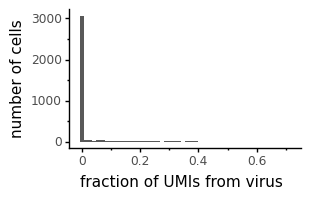

In [17]:
p = (ggplot(adata.obs.query('not filtered'), aes('viral_UMI_frac')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('fraction of UMIs from virus') +
     ylab('number of cells')
     )
_ = p.draw()

Make the same plot filtering on cells with at least 1% of their UMIs from virus.
Note that we haven't yet established a rigorous cutoff for which cells are truly infected, but filtering for at least 1% of UMIs from virus probably gets rid of most uninfected cells:

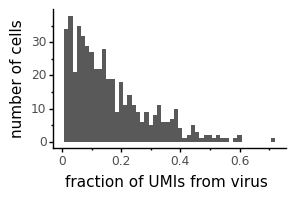

In [18]:
p = (ggplot(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)'), 
            aes('viral_UMI_frac')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('fraction of UMIs from virus') +
     ylab('number of cells')
     )
_ = p.draw()

### Fraction of cells infected
Want a simple estimate of what proportion of all filtered cells are infected. For now, I will simply use a cutoff of >=1% of UMIs come from viral genes.

In [19]:
single_cells = len(adata.obs.query('(not filtered)'))
infected_cells = len(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)'))
frac_infected = infected_cells / single_cells * 100

print(f"The total number of single cells is: {single_cells} cells.")
print(f"Of these, {infected_cells} are likely bona fide infected cells. These droplets derive at least 1% of their UMIs from viral genes.")
print(f"This is {frac_infected:.1f}% of cells in the dataset.")

The total number of single cells is: 3574 cells.
Of these, 495 are likely bona fide infected cells. These droplets derive at least 1% of their UMIs from viral genes.
This is 13.9% of cells in the dataset.


I will make a plot of these cells showing the fraction of UMI from virus in each.

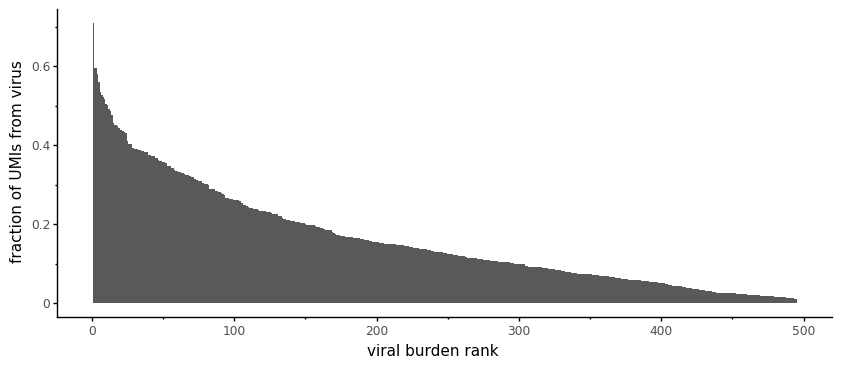

In [20]:
working_df = adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)')
working_df = working_df.sort_values(by=['viral_UMI_frac'], ascending=False)
working_df['viral_UMI_frac_rank'] = working_df.reset_index().index + 1

p = (ggplot(working_df, 
            aes(x='viral_UMI_frac_rank', y='viral_UMI_frac')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(10, 4)) +
     xlab('viral burden rank') +
     ylab('fraction of UMIs from virus')
     )
_ = p.draw()

### Variant infecting each cell
I'd like to label each cell as being infected by WT or dblSyn virus. I expect some leakage of transcripts from droplet to droplet, so there may be a few reads of the opposite type. Overall, I expect most cells which are truly infected will have the vast majority of their reads from one variant or the other.

#### Loading tag counts
A lot of cell barcodes have no value for either the WT tag count or the dblSyn tag count, or both. To deal with this, **I will add a pseudocount to all tag count values**. Since many cells only have a few tag counts, I will make this fractional and quite small. I choose `0.003` as an arbitrary value, which is 3 orders of magnitude smaller than my real values, so should not affect ratios much at all.

I will call cell as infected by either WT or dblSyn variant of virus, based on ratio of tag counts. I made arbitrary cutoffs using 0.3 and .7 as the ratios. These are at least reciprocal. I will interpret any ratio between these cutoffs is mixed.

In [21]:
# Load counts of each viral tag from `viraltag_counts.csv`
print(f"Reading viral tag counts from {input_viraltag_counts}")
tag_counts_df = pd.read_csv(input_viraltag_counts)

tag_counts_df = tag_counts_df.rename(columns={'cell_barcode':'cell_barcodes'})

tag_counts_df = tag_counts_df.groupby(['cell_barcodes','tag_variant']).sum()
tag_counts_df = tag_counts_df.reset_index(level=['cell_barcodes','tag_variant'])
tag_counts_df = tag_counts_df.pivot_table('count', ['cell_barcodes'], 'tag_variant')
tag_counts_df = tag_counts_df.fillna(0)

Reading viral tag counts from results/viral_fastq10x/viraltag_counts_hashing_trial2.csv


In [22]:
fraction_cutoff = 0.3 #Set a 30% contamination fraction as the cutoff for mixed calls.

tag_counts_df['total_tags'] = (tag_counts_df['syn'] + tag_counts_df['wt'])
tag_counts_df['syn_frac'] = tag_counts_df['syn'] / tag_counts_df['total_tags']

tag_counts_df['variant'] = 'mixed'

tag_counts_df.loc[tag_counts_df['syn_frac'] < fraction_cutoff, 'variant'] = 'wt'
tag_counts_df.loc[tag_counts_df['syn_frac'] > 1-fraction_cutoff, 'variant'] = 'syn'
tag_counts_df.loc[tag_counts_df['total_tags'] == 0, 'variant'] = 'no tags'
tag_counts_df = tag_counts_df.reset_index()
tag_counts_df = tag_counts_df.sort_values(by=['syn_frac'], ascending=False)
tag_counts_df['syn_frac_rank'] = tag_counts_df.reset_index().index + 1

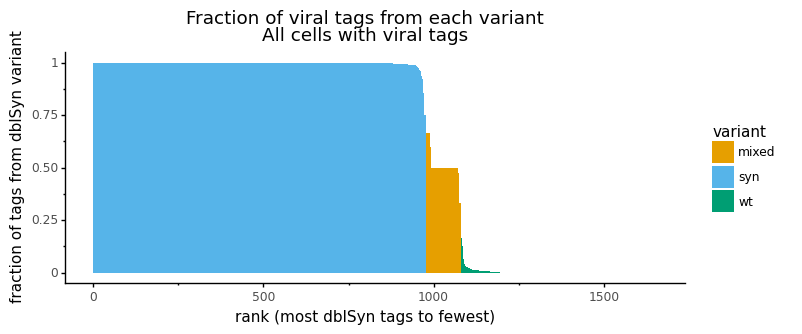

In [23]:
p = (ggplot(tag_counts_df, 
            aes(x='syn_frac_rank', y='syn_frac', fill='variant')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(8, 3)) +
     ggtitle('Fraction of viral tags from each variant\nAll cells with viral tags') +
     xlab('rank (most dblSyn tags to fewest)') +
     ylab('fraction of tags from dblSyn variant') +
     scale_fill_manual(values=cbpalette[1:])
     )
_ = p.draw()

#### Calling the variant of each infected cell
Now, I will take the tag count and variant identity information I just calculated and merge it with the infection status information I calculated above. This will give the variant call for each "true" infected cell.

In [24]:
adata.obs = adata.obs.merge(tag_counts_df, on='cell_barcodes', how='outer')
adata.obs

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


,cell_barcodes,total_UMIs,viral_UMIs,cellular_UMIs,viral_UMI_frac,filtered,filtered_desc,syn,wt,total_tags,syn_frac,variant,syn_frac_rank
0,AAACCCAAGGTCGAGT,1073.0,0.0,1073.0,0.000000,False,retained,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCCACAAAGAACT,983.0,3.0,980.0,0.003052,False,retained,2.0,1.0,3.0,0.666667,mixed,983.0
2,AAACCCAGTACTGGGA,349.0,0.0,349.0,0.000000,True,too few cellular UMIs,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCCATCCCTCAAC,1208.0,0.0,1208.0,0.000000,False,retained,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCCATCGAGCCTG,1105.0,0.0,1105.0,0.000000,False,retained,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,TTTGTTGCAAACTAGA,1543.0,91.0,1452.0,0.058976,False,retained,66.0,0.0,66.0,1.000000,syn,601.0
3730,TTTGTTGGTCATCGGC,1013.0,2.0,1011.0,0.001974,False,retained,NaN,NaN,NaN,NaN,NaN,NaN
3731,TTTGTTGGTTTGCAGT,1037.0,0.0,1037.0,0.000000,False,retained,NaN,NaN,NaN,NaN,NaN,NaN
3732,TTTGTTGTCCGCACGA,374.0,105.0,269.0,0.280749,True,too few cellular UMIs,0.0,68.0,68.0,0.000000,wt,1291.0


In [25]:
single_cells = len(adata.obs.query('(not filtered)'))
    
print(f"The total number of retained single cells is: {single_cells} cells.")
print(f"I assume half of these ({single_cells/2:.0f} cells) were from the well infected",
      "with WT virus and half were from the well infected with dblSyn.\n")

for var in ['wt','syn', 'mixed', 'no tags']:
    infected_cells = len(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01) & (variant == @var)'))
    frac_infected = infected_cells / (single_cells / 2) * 100

    if var == 'wt' or var == 'syn':
        print(f"There were {infected_cells} cells called as infected with {var} virus.")
        print(f"Assuming half the total single cells came from this sample well, {frac_infected:.0f}% of the cells in that well were infected.\n")
    else:
        print(f"There were {infected_cells} droplets called as {var}.")
    

The total number of retained single cells is: 3574 cells.
I assume half of these (1787 cells) were from the well infected with WT virus and half were from the well infected with dblSyn.

There were 216 cells called as infected with wt virus.
Assuming half the total single cells came from this sample well, 12% of the cells in that well were infected.

There were 276 cells called as infected with syn virus.
Assuming half the total single cells came from this sample well, 15% of the cells in that well were infected.

There were 3 droplets called as mixed.
There were 0 droplets called as no tags.


Plot the proportions of tag counts for each true infected cell.

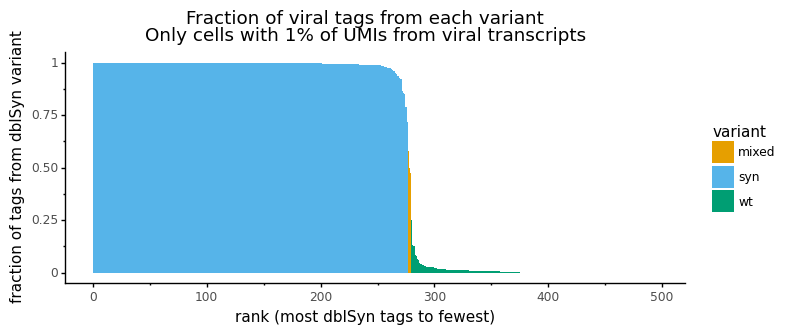

In [26]:
working_df = adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)')
working_df = working_df.sort_values(by=['syn_frac'], ascending=False)
working_df['syn_frac_rank'] = working_df.reset_index().index + 1
p = (ggplot(working_df, 
            aes(x='syn_frac_rank', y='syn_frac', fill='variant')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(8, 3)) +
     ggtitle('Fraction of viral tags from each variant\nOnly cells with 1% of UMIs from viral transcripts') +
     xlab('rank (most dblSyn tags to fewest)') +
     ylab('fraction of tags from dblSyn variant') +
     scale_fill_manual(values=cbpalette[1:])
     )
_ = p.draw()